In [3]:
import numpy as np
import pandas as pd

import os
from matplotlib import pyplot as plt

import klampt
from klampt.model import ik

world = klampt.WorldModel()
robot_path = "/home/luca/Klampt-examples/data/robots/pr2.rob"
robot_record_dir = "robot_records"
num_ik_solutions = 3000
num_subplots = 5
num_ticks = 5

In [4]:
robot_name = robot_path.split("/")[-1].split(".")[0]
world.loadElement(robot_path)

robot = world.robot(0)
robot.randomizeConfig()
lastLink = robot.link(robot.numLinks()-1)
link = lastLink
print(robot.getConfig())
R = link.getTransform()[0]
t = link.getTransform()[1]
obj = ik.objective(link, R=R, t=t)


ikSolutions = np.zeros((num_ik_solutions, robot.numLinks()))

i = 0
while i < num_ik_solutions:
    solved = ik.solve_global(
        obj,
        iters=1000,
        tol=1e-3,
        activeDofs=None,
        numRestarts=100,
        feasibilityCheck=None,
        startRandom=True,
    )
    if solved:
        ikSolutions[i] = robot.getConfig()
        i += 1
        
df = pd.DataFrame(ikSolutions)

# remove columns with std smaller than 1e-4
df = df.loc[:, df.std() > 1e-4]
num_dofs = df.shape[1]
print(f"Number of DOFs: {num_dofs}")
df.describe()

WorldModel::LoadRobot: /home/luca/Klampt-examples/data/robots/pr2.rob
[0.0, 0.0, 0.0, 0.0, 0.0, 0.4638292503953093, 0.0, 0.0, 0.0, 4.506909527896467, 0.8897150952706678, 3.8136979252136554, 0.10241951212861611, 1.5261025885290616, 0.8622514269429999, 5.052791566534395, 0.984443751543543, 2.51920792692364, 0.8154974282295167, 0.6836658661801259, 6.276427854501412, 0.07202477875259927, 0.07777541994805226, 1.0958024200639747, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.123318723066649, 0.04475110281712902, 2.1964956582041903, 0.0, -1.1042721456979736, 3.101273371733949, 0.0, 0.0, 0.0, -0.05935044793381827, 1.8379371619273501, 0.0, 0.42270401839106536, 0.2886562486089097, 0.0, 0.0, 0.05398276725503745, 2.514710597829737, 0.4885581396988399, 0.15525648081081755, 0.0, 0.0, 0.0, 0.014303317859728604, 0.0, 0.13777517547568818, 1.2408389273654854, -3.572150201710011, 0.0, -0.11762705995595413, 3.304926

,0,1,2,3,4,5,99
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.153123,-0.005599,-0.003045,-47.450214,0.019420,-0.009727,3.110863
std,0.100182,0.099704,0.049868,18.616854,0.341830,0.316053,2.059699
min,-0.301198,-0.134281,-0.067784,-82.630717,-0.464320,-0.463818,-1.467391
25%,-0.247577,-0.110099,-0.055278,-61.412103,-0.331313,-0.314362,1.695669
50%,-0.154284,-0.012319,-0.006189,-49.923652,0.040696,-0.014284,2.958767
75%,-0.062002,0.097507,0.048509,-36.543260,0.375450,0.285507,4.697588
max,0.001040,0.135479,0.067165,0.275595,0.464801,0.463795,7.871910


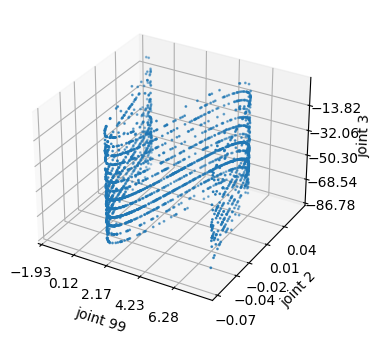

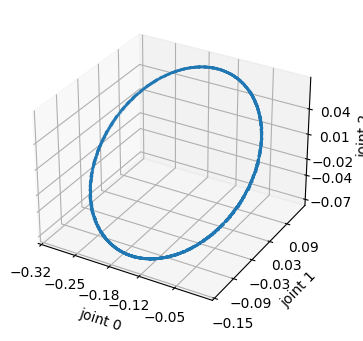

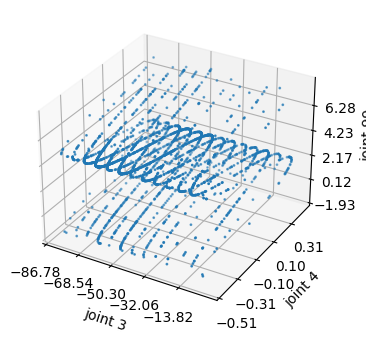

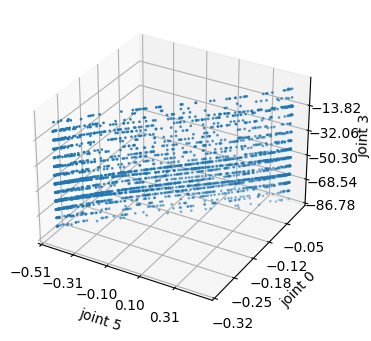

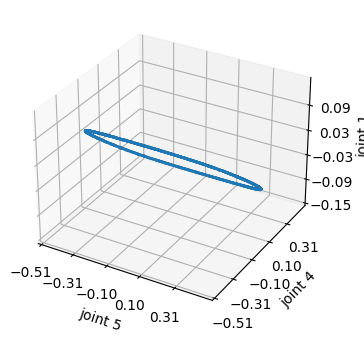

In [5]:
# generate num_subplots times random joint idx at once
subplot_columns = np.array([np.random.choice(df.columns, 3, replace=False) for _ in range(num_subplots)])

# generate 3 times random visualization
for i in range(num_subplots):
    fig = plt.figure(figsize=(4, 5))
    
    # random pick up 3 columns and sort them 
    columns = subplot_columns[i]

    ax = fig.add_subplot(projection='3d')

    # plot data points by axis = these 3 columns
    ax.scatter(df[columns[0]], df[columns[1]], df[columns[2]], s=1)

    # set labels
    ax.set_xlabel(f"joint {columns[0]}")
    ax.set_ylabel(f"joint {columns[1]}")
    ax.set_zlabel(f"joint {columns[2]}")
    
    num_digits = 2
    start, end = ax.get_xlim()
    step = (end - start) / num_ticks
    ax.xaxis.set_ticks(np.round(np.arange(start, end, step), num_digits))

    start, end = ax.get_ylim()
    step = (end - start) / num_ticks
    ax.yaxis.set_ticks(np.round(np.arange(start, end, step),num_digits))
    
    start, end = ax.get_zlim()
    step = (end - start) / num_ticks
    ax.zaxis.set_ticks(np.round(np.arange(start, end, step), num_digits))
    
    # if not exist, create directory
    if not os.path.exists(f"{robot_record_dir}/{robot_name}"):
        os.makedirs(f"{robot_record_dir}/{robot_name}")
    
    # save figure by robot name and random number
    fig.savefig(f"{robot_record_dir}/{robot_name}/scatter_{i}.png")


In [6]:
from hnne import HNNE

hnne = HNNE()
projection = hnne.fit_transform(df.values)
partitions = np.array(hnne.hierarchy_parameters.partitions)
partition_sizes = np.array(hnne.hierarchy_parameters.partition_sizes)

# choose the partition with the size closest to 20
partition_index = np.argmin(np.abs(partition_sizes - 20))
partition = partitions[:, partition_index]

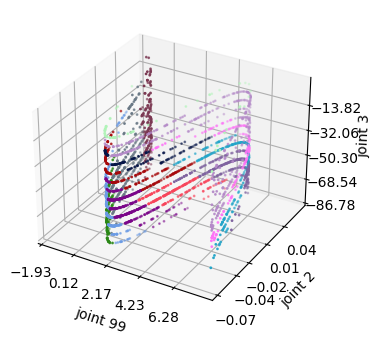

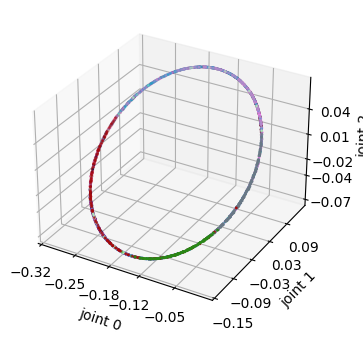

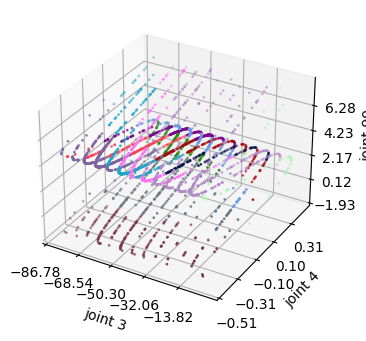

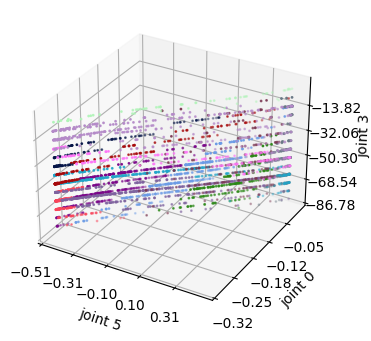

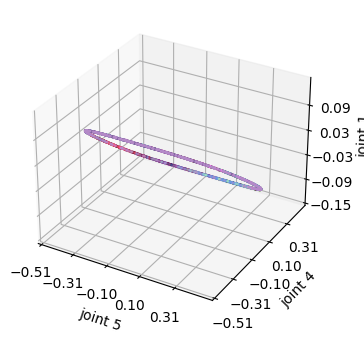

In [7]:
# generate 3 time random visualization with data points colored by partition
# and assign a color to each partition
colors = np.random.rand(partition.max() + 1, 3)

for i in range(num_subplots):
    fig = plt.figure(figsize=(4, 5))
    
    columns = subplot_columns[i]

    ax = fig.add_subplot(projection='3d')

    for p in range(partition.max() + 1):
        mask = partition == p
        ax.scatter(
            df.loc[mask, columns[0]],
            df.loc[mask, columns[1]],
            df.loc[mask, columns[2]],
            s=1,
            color=colors[p],
        )

    ax.set_xlabel(f"joint {columns[0]}")
    ax.set_ylabel(f"joint {columns[1]}")
    ax.set_zlabel(f"joint {columns[2]}")
    
    num_digits = 2
    start, end = ax.get_xlim()
    step = (end - start) / num_ticks
    ax.xaxis.set_ticks(np.round(np.arange(start, end, step), num_digits))

    start, end = ax.get_ylim()
    step = (end - start) / num_ticks
    ax.yaxis.set_ticks(np.round(np.arange(start, end, step),num_digits))
    
    start, end = ax.get_zlim()
    step = (end - start) / num_ticks
    ax.zaxis.set_ticks(np.round(np.arange(start, end, step), num_digits))
    
    if not os.path.exists(f"{robot_record_dir}/{robot_name}"):
        os.makedirs(f"{robot_record_dir}/{robot_name}")
    
    fig.savefig(f"{robot_record_dir}/{robot_name}/scatter_{i}_partition.png")


In [ ]:
from paik.solver import Solver
from paik.settings import PANDA_NSF, PANDA_PAIK